In [24]:
from glob import glob
from multiprocessing import Pool, cpu_count

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import tensorflow as tf
from tqdm import tqdm

In [2]:
F = "/app/_data/competition_data/train_soundscapes/20152_SSW_20170805.ogg"

In [3]:
F = "/app/_data/competition_data/train_short_audio/acafly/XC580740.ogg"

In [4]:
ipd.Audio(F)

In [57]:
x, sr = librosa.load(F)
x.shape, x.dtype, sr

((361202,), dtype('float32'), 22050)

In [ ]:
paths = glob("/app/_data/competition_data/train_short_audio/**/*.ogg")


def audio_to_sr(path):
    x, sr = librosa.load(path)
    return sr


with Pool(cpu_count()) as pool:
    srs = list(
        tqdm(
            pool.imap(
                audio_to_sr,
                paths,
            ),
            total=len(paths),
            smoothing=0,
        )
    )

In [6]:
def wave_to_msg(x, sr, n_fft=2048, hop_length=512, n_mels=128):
    S = librosa.feature.melspectrogram(
        x,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

In [ ]:
# benchmark spectrogram generation

/usr/local/lib/python3.8/dist-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/dist-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


(256, 257)


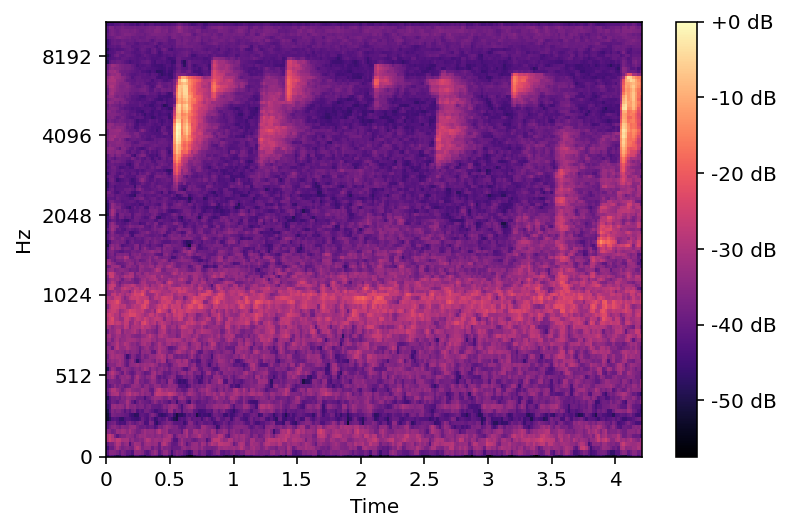

In [58]:
x, sr = librosa.load(F)
x = x[: sr * 5]  # trim to 5s

target_msg_h = 256
target_msg_w = 256
hop_length = x.shape[0] // target_msg_w
msg = wave_to_msg(x, sr, hop_length=hop_length, n_mels=target_msg_h)

librosa.display.specshow(
    wave_to_msg(x, sr),
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel"
)

plt.colorbar(format="%+2.0f dB");
print(msg.shape)

In [101]:
hop_length

430

In [17]:
for i in tqdm(range(1000)):
    msg = wave_to_msg(x, sr, hop_length=hop_length, n_mels=target_msg_h)

100%|██████████| 1000/1000 [00:16<00:00, 58.90it/s]


In [16]:
x, sr = librosa.load(F)
x = x[: sr * 5]  # trim to 5s


def _map(_):
    wave_to_msg(
        x,
        sr,
        hop_length=x.shape[0] // 256,
        n_mels=256,
    )


with Pool(cpu_count()*0+10) as pool:
    _ = list(
        tqdm(
            pool.imap(
                _map,
                range(1000),
            ),
            total=1000,
            smoothing=0,
        )
    )

100%|██████████| 1000/1000 [00:20<00:00, 48.38it/s]


In [35]:
# ! wget https://www.kozco.com/tech/LRMonoPhase4.wav

# audio_binary = tf.io.read_file("LRMonoPhase4.wav")

# tf.contrib.ffmpeg not supported on Windows, refer to issue
# https://github.com/tensorflow/tensorflow/issues/8271
# waveform = tf.audio.decode_wav(audio_binary, desired_channels=1)

# waveform.audio.shape

# signals = tf.reshape(waveform.audio, [1, -1])

In [59]:
x = x.reshape(1, -1)

In [61]:
# Step 1 : signals->stfts
# `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
# each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
# where fft_unique_bins = fft_length // 2 + 1 = 513.


stfts = tf.signal.stft(
    x, frame_length=1024, frame_step=512, fft_length=1024
)

# Step2 : stfts->magnitude_spectrograms
# An energy spectrogram is the magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
magnitude_spectrograms = tf.abs(stfts)

In [66]:
# Step 3 : magnitude_spectrograms->mel_spectrograms
# Warp the linear-scale, magnitude spectrograms into the mel-scale.
num_spectrogram_bins = magnitude_spectrograms.shape[-1]

num_mel_bins = 64

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins,
    num_spectrogram_bins=num_spectrogram_bins,
    sample_rate=22500,
    lower_edge_hertz=20,
    upper_edge_hertz=11250,
)

In [67]:
mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

In [70]:
# Step 4 : mel_spectrograms->log_mel_spectrograms
log_offset = 1e-6
log_mel_spectrograms = tf.math.log(mel_spectrograms + log_offset)

num_mfccs = 13

# Step 5 : log_mel_spectrograms->mfccs
# Keep the first `num_mfccs` MFCCs.
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[
    ..., :num_mfccs
]

In [73]:
m = mfccs.numpy()

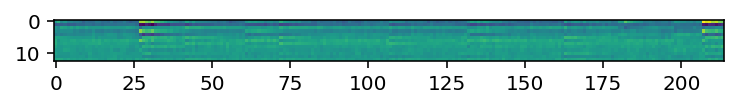

In [79]:
plt.imshow(m[0].T)